# PROJECT-1. Угадай знаменитость

Представьте следующую ситуацию.

Вы стажируетесь в стартапе и вместе с командой работаете над улучшением сервиса по распознаванию лиц. Вашей компании поступил запрос на применение разработанного сервиса в рамках IT-конференции, спикерами на которой будут эти знаменитые люди!

![Знаменитости](https://lms-cdn.skillfactory.ru/assets/courseware/v1/8c3ed80a5e98e9930fa8262c0eb61cba/asset-v1:SkillFactory+DSPR-CV+ALWAYS+type@asset+block/cv_project1_1_1.png)

Всех узнали? ;) Отлично! Теперь давайте поможем и камерам их узнавать. Для этого **обучим пятиклассовый классификатор, используя всю мощь предобученных сетей!**

## Загрузка библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
%matplotlib inline

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn
from torchvision import models

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


## Загрузка данных

In [2]:
!gdown -q 120xqh0mYtYZ1Qh7vr-XFzjPbSKivLJjA
!unzip -o -qqq CV_project1_data.zip
!rm -f CV_project1_data.zip
!ls -1 ./data/

train
valid


In [3]:
train_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(70),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(70),
    transforms.ToTensor(),
])

In [4]:
train_data = ImageFolder("data/train", transform=train_transform)
val_data = ImageFolder("data/valid", transform=val_transform)

BATCH_SIZE = 16

train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)
val_loader = DataLoader(
    val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)

In [5]:
classes = [x.replace("_", " ").title() for x in train_data.classes]
classes

['Bill Gates', 'Elon Musk', 'Jeff Bezos', 'Mark Zuckerberg', 'Steve Jobs']

## Визуализация данных

In [6]:
print("Train dataset entries:", train_data.__len__())
print("Validation dataset entries:", val_data.__len__())

Train dataset entries: 3000
Validation dataset entries: 914


['Jeff Bezos', 'Mark Zuckerberg', 'Elon Musk', 'Mark Zuckerberg', 'Elon Musk', 'Steve Jobs', 'Bill Gates', 'Jeff Bezos', 'Mark Zuckerberg', 'Jeff Bezos', 'Jeff Bezos', 'Bill Gates', 'Jeff Bezos', 'Elon Musk', 'Bill Gates', 'Jeff Bezos']


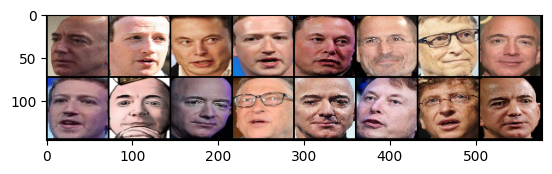

In [7]:
# Загружаем 1 батч изображений и меток
images, labels = next(iter(train_loader))

# Преобразуем батч изображений в сетку
img = torchvision.utils.make_grid(images)
img = img.numpy().transpose((1,2,0))

print([classes[i] for i in labels])
plt.imshow(img)
plt.show()

## VGG16

### Загрузка модели

In [8]:
model_vgg = models.vgg16(weights='DEFAULT')
print(model_vgg)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 213MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Обучение классификатора модели

In [9]:
# Замораживаем веса модели во время обратного распространения ошибки
for param in model_vgg.parameters():
    param.requires_grad = False

# Фиксируем количество нейронов на входе выходного слоя классификатора
n_inputs = model_vgg.classifier[-1].in_features

# Заменим этот слой на новый, выходное количество нейронов которого соответствует нашей задаче классификации
n_classes = len(classes)
model_vgg.classifier[-1] = nn.Linear(n_inputs, n_classes)

model_vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)

In [10]:
# Убеждаемся в обновляемости весов нового слоя
for name, param in model_vgg.classifier.named_parameters():
    print('Name: ', name, ' Requires_Grad: ', param.requires_grad)

Name:  0.weight  Requires_Grad:  False
Name:  0.bias  Requires_Grad:  False
Name:  3.weight  Requires_Grad:  False
Name:  3.bias  Requires_Grad:  False
Name:  6.weight  Requires_Grad:  True
Name:  6.bias  Requires_Grad:  True


In [11]:
# Выбираем лучшее из доступных устройств
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vgg = model_vgg.to(device)

# Определяем лосс-функцию и создаем оптимизатор
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg.classifier.parameters())

# Объединяем даталоадеры в один объект
dataloaders = {'train': train_loader, 'val': val_loader}

In [12]:
def train_model(model, device, dataloaders, criterion, optimizer, batch_size, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        # На каждой эпохе происходит обучение и валидация
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проходим по данным
            for inputs, labels in tqdm(dataloaders[phase]):
                batch += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем прогноз модели и считаем лосс
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)

            epoch_loss = current_loss / dataloaders[phase].dataset.__len__()
            epoch_acc = current_corrects.double() / dataloaders[phase].dataset.__len__()

            print('Phase: {}, Loss: {:.3f}, Acc: {:.3f}'.format(phase, epoch_loss, epoch_acc))
        print('-' * 60)

    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [13]:
celebs_vgg = train_model(model_vgg, device, dataloaders, criterion, optimizer, batch_size=BATCH_SIZE, num_epochs=10)

Epoch 1/10


100%|██████████| 188/188 [00:10<00:00, 18.15it/s]


Phase: train, Loss: 0.772, Acc: 0.709


100%|██████████| 58/58 [00:01<00:00, 40.12it/s]


Phase: val, Loss: 0.601, Acc: 0.795
------------------------------------------------------------
Epoch 2/10


100%|██████████| 188/188 [00:03<00:00, 59.09it/s]


Phase: train, Loss: 0.588, Acc: 0.800


100%|██████████| 58/58 [00:01<00:00, 54.81it/s]


Phase: val, Loss: 0.516, Acc: 0.827
------------------------------------------------------------
Epoch 3/10


100%|██████████| 188/188 [00:03<00:00, 58.57it/s]


Phase: train, Loss: 0.570, Acc: 0.786


100%|██████████| 58/58 [00:01<00:00, 54.38it/s]


Phase: val, Loss: 0.472, Acc: 0.850
------------------------------------------------------------
Epoch 4/10


100%|██████████| 188/188 [00:04<00:00, 46.00it/s]


Phase: train, Loss: 0.532, Acc: 0.804


100%|██████████| 58/58 [00:01<00:00, 51.44it/s]


Phase: val, Loss: 0.470, Acc: 0.845
------------------------------------------------------------
Epoch 5/10


100%|██████████| 188/188 [00:03<00:00, 58.67it/s]


Phase: train, Loss: 0.530, Acc: 0.808


100%|██████████| 58/58 [00:01<00:00, 54.45it/s]


Phase: val, Loss: 0.433, Acc: 0.858
------------------------------------------------------------
Epoch 6/10


100%|██████████| 188/188 [00:03<00:00, 58.66it/s]


Phase: train, Loss: 0.496, Acc: 0.814


100%|██████████| 58/58 [00:01<00:00, 50.24it/s]


Phase: val, Loss: 0.439, Acc: 0.880
------------------------------------------------------------
Epoch 7/10


100%|██████████| 188/188 [00:04<00:00, 45.50it/s]


Phase: train, Loss: 0.516, Acc: 0.820


100%|██████████| 58/58 [00:01<00:00, 55.26it/s]


Phase: val, Loss: 0.418, Acc: 0.867
------------------------------------------------------------
Epoch 8/10


100%|██████████| 188/188 [00:03<00:00, 58.35it/s]


Phase: train, Loss: 0.503, Acc: 0.821


100%|██████████| 58/58 [00:01<00:00, 54.37it/s]


Phase: val, Loss: 0.427, Acc: 0.874
------------------------------------------------------------
Epoch 9/10


100%|██████████| 188/188 [00:03<00:00, 58.94it/s]


Phase: train, Loss: 0.481, Acc: 0.823


100%|██████████| 58/58 [00:01<00:00, 52.72it/s]


Phase: val, Loss: 0.449, Acc: 0.854
------------------------------------------------------------
Epoch 10/10


100%|██████████| 188/188 [00:04<00:00, 46.41it/s]


Phase: train, Loss: 0.498, Acc: 0.839


100%|██████████| 58/58 [00:01<00:00, 53.83it/s]

Phase: val, Loss: 0.370, Acc: 0.881
------------------------------------------------------------
Время обучения: 0m 53s


### Визуализация результатов предсказаний

In [14]:
def visualize_model(model, device, num_images=6):
    n_cols = 6
    n_rows = (num_images + n_cols - 1) // n_cols
    plt.figure(figsize=(2 * n_cols, 2 * n_rows))
    model.eval()

    with torch.no_grad():
        images, labels = next(iter(dataloaders['val']))
        inputs = images.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(num_images):
            plt.subplot(n_rows, n_cols, j + 1)
            plt.axis('off')
            plt.title(
                'pred: {}\ntrue: {}'.format(classes[preds[j]], classes[labels[j]]),
                fontsize=9
            )
            img = images[j]
            img = img.numpy().transpose((1, 2, 0))
            plt.imshow(img, vmin=0, vmax=1)

    plt.show()

In [ ]:
# https://albumentations.ai/docs/examples/pytorch_classification/
# 
# def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
#     rows = len(images_filepaths) // cols
#     figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
#     for i, image_filepath in enumerate(images_filepaths):
#         image = cv2.imread(image_filepath)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
#         predicted_label = predicted_labels[i] if predicted_labels else true_label
#         color = "green" if true_label == predicted_label else "red"
#         ax.ravel()[i].imshow(image)
#         ax.ravel()[i].set_title(predicted_label, color=color)
#         ax.ravel()[i].set_axis_off()
#     plt.tight_layout()
#     plt.show()

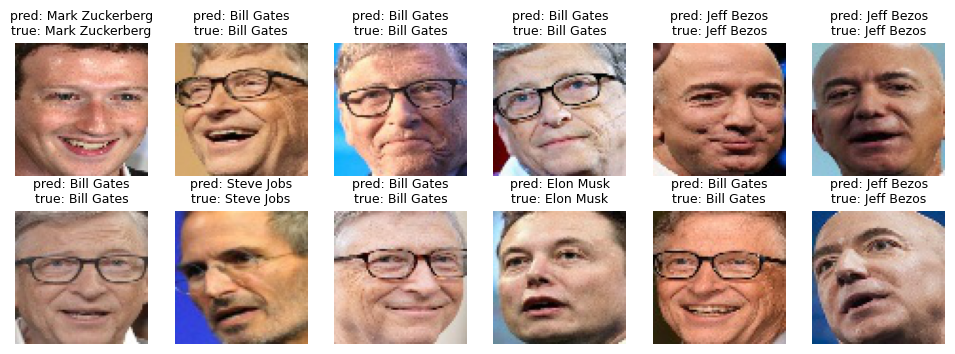

In [15]:
visualize_model(celebs_vgg, device, 12)

## EfficientNet_B7

In [16]:
model_en_b7 = models.efficientnet_b7(weights='DEFAULT')
print(model_en_b7)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:03<00:00, 85.8MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [17]:
# Замораживаем веса модели во время обратного распространения ошибки
for param in model_en_b7.parameters():
    param.requires_grad = False

# Фиксируем количество нейронов на входе выходного слоя классификатора
n_inputs = model_en_b7.classifier[-1].in_features

# Меняем этот слой на новый с соответствующим количеством выходов для нашей задачи классификации
n_classes = len(classes)
model_en_b7.classifier[-1] = nn.Linear(n_inputs, n_classes)

model_en_b7.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=5, bias=True)
)

In [18]:
# Переносим модель на доступное устройство
model_en_b7 = model_en_b7.to(device)

# Создаем оптимизатор для данной модели
optimizer = torch.optim.Adam(model_en_b7.classifier.parameters())

In [19]:
celebs_en_b7 = train_model(model_en_b7, device, dataloaders, criterion, optimizer, batch_size=BATCH_SIZE, num_epochs=10)

Epoch 1/10


100%|██████████| 188/188 [00:12<00:00, 14.82it/s]


Phase: train, Loss: 1.176, Acc: 0.575


100%|██████████| 58/58 [00:03<00:00, 17.67it/s]


Phase: val, Loss: 1.096, Acc: 0.605
------------------------------------------------------------
Epoch 2/10


100%|██████████| 188/188 [00:11<00:00, 17.00it/s]


Phase: train, Loss: 0.887, Acc: 0.686


100%|██████████| 58/58 [00:03<00:00, 16.20it/s]


Phase: val, Loss: 0.850, Acc: 0.712
------------------------------------------------------------
Epoch 3/10


100%|██████████| 188/188 [00:10<00:00, 17.48it/s]


Phase: train, Loss: 0.854, Acc: 0.688


100%|██████████| 58/58 [00:03<00:00, 18.74it/s]


Phase: val, Loss: 0.795, Acc: 0.732
------------------------------------------------------------
Epoch 4/10


100%|██████████| 188/188 [00:11<00:00, 16.47it/s]


Phase: train, Loss: 0.813, Acc: 0.705


100%|██████████| 58/58 [00:02<00:00, 21.05it/s]


Phase: val, Loss: 0.759, Acc: 0.740
------------------------------------------------------------
Epoch 5/10


100%|██████████| 188/188 [00:11<00:00, 16.46it/s]


Phase: train, Loss: 0.780, Acc: 0.717


100%|██████████| 58/58 [00:02<00:00, 21.01it/s]


Phase: val, Loss: 0.728, Acc: 0.758
------------------------------------------------------------
Epoch 6/10


100%|██████████| 188/188 [00:12<00:00, 15.05it/s]


Phase: train, Loss: 0.787, Acc: 0.711


100%|██████████| 58/58 [00:02<00:00, 20.60it/s]


Phase: val, Loss: 0.719, Acc: 0.752
------------------------------------------------------------
Epoch 7/10


100%|██████████| 188/188 [00:11<00:00, 16.56it/s]


Phase: train, Loss: 0.784, Acc: 0.705


100%|██████████| 58/58 [00:02<00:00, 19.33it/s]


Phase: val, Loss: 0.715, Acc: 0.751
------------------------------------------------------------
Epoch 8/10


100%|██████████| 188/188 [00:11<00:00, 16.45it/s]


Phase: train, Loss: 0.765, Acc: 0.723


100%|██████████| 58/58 [00:03<00:00, 17.78it/s]


Phase: val, Loss: 0.699, Acc: 0.760
------------------------------------------------------------
Epoch 9/10


100%|██████████| 188/188 [00:11<00:00, 16.79it/s]


Phase: train, Loss: 0.751, Acc: 0.737


100%|██████████| 58/58 [00:03<00:00, 14.93it/s]


Phase: val, Loss: 0.688, Acc: 0.770
------------------------------------------------------------
Epoch 10/10


100%|██████████| 188/188 [00:11<00:00, 16.75it/s]


Phase: train, Loss: 0.790, Acc: 0.709


100%|██████████| 58/58 [00:03<00:00, 17.32it/s]

Phase: val, Loss: 0.680, Acc: 0.778
------------------------------------------------------------
Время обучения: 2m 27s


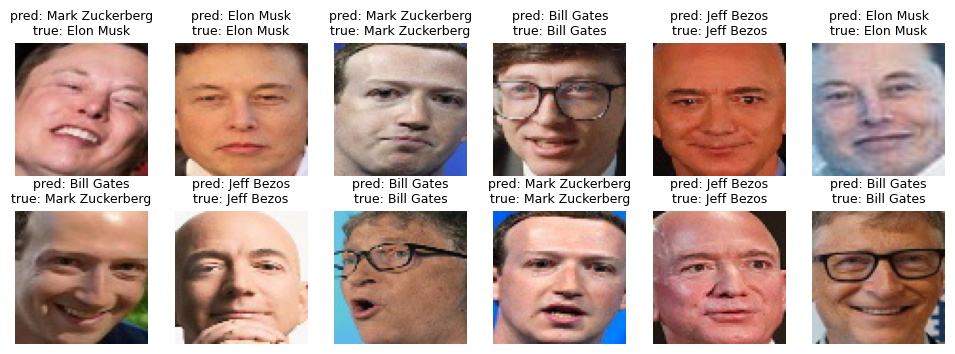

In [20]:
visualize_model(celebs_en_b7, device, 12)

## ResNet34

In [21]:
model_resnet = models.resnet34(weights='DEFAULT')
print(model_resnet)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Замораживаем веса модели во время обратного распространения ошибки
for param in model_resnet.parameters():
    param.requires_grad = False

# Фиксируем количество нейронов на входе выходного слоя классификатора
n_inputs = model_resnet.fc.in_features

# Меняем этот слой на новый с соответствующим количеством выходов для нашей задачи классификации
n_classes = len(classes)
model_resnet.fc = nn.Linear(n_inputs, n_classes)

model_resnet.fc

Linear(in_features=512, out_features=5, bias=True)

In [23]:
# Переносим модель на доступное устройство
model_resnet = model_resnet.to(device)

# Создаем оптимизатор для данной модели
optimizer = torch.optim.Adam(model_resnet.fc.parameters())

In [24]:
celebs_resnet = train_model(model_resnet, device, dataloaders, criterion, optimizer, batch_size=BATCH_SIZE, num_epochs=10)

Epoch 1/10


100%|██████████| 188/188 [00:04<00:00, 42.20it/s]


Phase: train, Loss: 1.074, Acc: 0.609


100%|██████████| 58/58 [00:01<00:00, 35.51it/s]


Phase: val, Loss: 0.713, Acc: 0.779
------------------------------------------------------------
Epoch 2/10


100%|██████████| 188/188 [00:04<00:00, 38.45it/s]


Phase: train, Loss: 0.688, Acc: 0.759


100%|██████████| 58/58 [00:01<00:00, 43.99it/s]


Phase: val, Loss: 0.589, Acc: 0.807
------------------------------------------------------------
Epoch 3/10


100%|██████████| 188/188 [00:04<00:00, 44.30it/s]


Phase: train, Loss: 0.641, Acc: 0.781


100%|██████████| 58/58 [00:01<00:00, 44.07it/s]


Phase: val, Loss: 0.499, Acc: 0.832
------------------------------------------------------------
Epoch 4/10


100%|██████████| 188/188 [00:05<00:00, 35.53it/s]


Phase: train, Loss: 0.564, Acc: 0.800


100%|██████████| 58/58 [00:01<00:00, 43.70it/s]


Phase: val, Loss: 0.479, Acc: 0.845
------------------------------------------------------------
Epoch 5/10


100%|██████████| 188/188 [00:04<00:00, 43.66it/s]


Phase: train, Loss: 0.542, Acc: 0.806


100%|██████████| 58/58 [00:01<00:00, 43.72it/s]


Phase: val, Loss: 0.470, Acc: 0.840
------------------------------------------------------------
Epoch 6/10


100%|██████████| 188/188 [00:05<00:00, 35.92it/s]


Phase: train, Loss: 0.510, Acc: 0.820


100%|██████████| 58/58 [00:01<00:00, 44.14it/s]


Phase: val, Loss: 0.472, Acc: 0.846
------------------------------------------------------------
Epoch 7/10


100%|██████████| 188/188 [00:04<00:00, 44.73it/s]


Phase: train, Loss: 0.508, Acc: 0.821


100%|██████████| 58/58 [00:01<00:00, 44.96it/s]


Phase: val, Loss: 0.445, Acc: 0.859
------------------------------------------------------------
Epoch 8/10


100%|██████████| 188/188 [00:05<00:00, 36.05it/s]


Phase: train, Loss: 0.484, Acc: 0.825


100%|██████████| 58/58 [00:01<00:00, 43.53it/s]


Phase: val, Loss: 0.483, Acc: 0.839
------------------------------------------------------------
Epoch 9/10


100%|██████████| 188/188 [00:04<00:00, 44.03it/s]


Phase: train, Loss: 0.500, Acc: 0.831


100%|██████████| 58/58 [00:01<00:00, 43.94it/s]


Phase: val, Loss: 0.471, Acc: 0.848
------------------------------------------------------------
Epoch 10/10


100%|██████████| 188/188 [00:05<00:00, 35.42it/s]


Phase: train, Loss: 0.479, Acc: 0.831


100%|██████████| 58/58 [00:01<00:00, 42.84it/s]

Phase: val, Loss: 0.495, Acc: 0.824
------------------------------------------------------------
Время обучения: 1m 1s


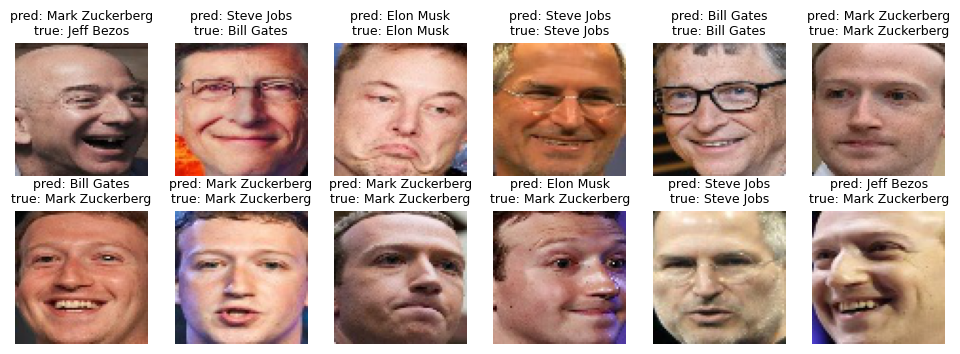

In [25]:
visualize_model(celebs_resnet, device, 12)

## Выводы

Были опробованы модели на архитектурах VGG16, EfficientNet_B7 и ResNet34:

* Модель на базе VGG16 дала наилучший результат с точки зрения качества прогноза и скорости обучения;

* ResNet34 показала близкий результат;

* Сеть EfficientNet_B7 оказалась заметно хуже для задачи распознавания лиц знаменитостей.